<a href="https://colab.research.google.com/github/MainakRepositor/Data-Analysis/blob/master/COVID_19_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Analysis and Prediction

## What is COVID-19?

### Coronavirus is a family of viruses that are named after their spiky crown("Corona" means "crown" in Spanish). The novel coronavirus, also known as SARS-CoV-2, is a contagious respiratory virus that first reported in Wuhan, China. On 11th February, 2020, the World Health Organization(WHO) designated the name COVID-19 for the disease caused by the novel coronavirus. This project aims at exploring COVID-19 spread through data analysis and predictions in the days to come

## In this project we will try to make machine learning models and predictions using three models. 
### 1. Support Vector Machine (SVM)
### 2. Polynomial Regression
### 3. Bayesian Ridge Polynomial Regression

### Modelling over the data, we will try to find out the agreement of the predicted results with the actual Covid-19 data. Based on the reults which we will obtain from it, we will make corresponding predictions and see how far the predictions are feasible with the real dataset.

### Finally we will plot the world confirmed,recovered, deaths and active cases and compare graphically with world. We will also try to compare some data in India with the world in terms of confirmed cases and recoveries.

<hr>

## 1. Importing necessary libraries

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
print("Necessary libraries included successfully!")

Necessary libraries included successfully!


## 2. Importing the datasets

In [3]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/11-14-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/11-14-2020.csv')
apple_mobility = pd.read_csv('https://covid19-static.cdn-apple.com/covid19-mobility-data/2021HotfixDev11/v3/en-us/applemobilitytrends-2020-11-14.csv')

print("All datasets are included successfully!")

All datasets are included successfully!


## 3. Glancing at the data

In [5]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-11-15 05:26:53,33.93911,67.709953,43035,1605,35067,6363.0,Afghanistan,110.549278,3.729522
1,NaN,NaN,NaN,Albania,2020-11-15 05:26:53,41.15330,20.168300,27233,612,12767,13854.0,Albania,946.313156,2.247274
2,NaN,NaN,NaN,Algeria,2020-11-15 05:26:53,28.03390,1.659600,66819,2139,44199,20481.0,Algeria,152.377219,3.201185
3,NaN,NaN,NaN,Andorra,2020-11-15 05:26:53,42.50630,1.521800,5725,75,4675,975.0,Andorra,7409.564486,1.310044
4,NaN,NaN,NaN,Angola,2020-11-15 05:26:53,-11.20270,17.873900,13374,322,6345,6707.0,Angola,40.692177,2.407657


## 4. Confirmed cases

In [6]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,39486,39548,39616,39693,39703,39799,39870,39928,39994,40026,40073,40141,40200,40287,40357,40510,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501,41633,41728,41814,41935,41975,42033,42092,42297,42463,42609,42795,42969,43035
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14568,14730,14899,15066,15231,15399,15570,15752,15955,16212,16501,16774,17055,17350,17651,17948,18250,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202,21523,21904,22300,22721,23210,23705,24206,24731,25294,25801,26211,26701,27233
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,52399,52520,52658,52804,52940,53072,53325,53399,53584,53777,53998,54203,54402,54616,54829,55081,55357,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272,58574,58979,59527,60169,60800,61381,62051,62693,63446,64257,65108,65975,66819
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2370,2568,2568,2696,2696,2696,2995,2995,3190,3190,3377,3377,3377,3623,3623,3811,3811,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825,4888,4910,5045,5135,5135,5319,5383,5437,5477,5567,5616,5725,5725
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5725,5725,5958,6031,6246,6366,6488,6680,6846,7096,7222,7462,7622,7829,8049,8338,8582,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035,11228,11577,11813,12102,12223,12335,12433,12680,12816,12953,13053,13228,13374


## 5. Clinical data

In [8]:
cols = confirmed_df.keys()

In [9]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

## 6. Formatting data for modelling and predictions

In [10]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

In [11]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)


# recoveries
world_daily_recovery = daily_increase(total_recovered)
world_recovery_avg = moving_average(total_recovered, window)
world_daily_recovery_avg = moving_average(world_daily_recovery, window)


# active 
world_active_avg = moving_average(total_active, window)


In [12]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [13]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [14]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [15]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases[50:], test_size=0.05, shuffle=False) 

## 7. Using SVM

In [16]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 1899787.4508340731
MSE: 3651534133333.528


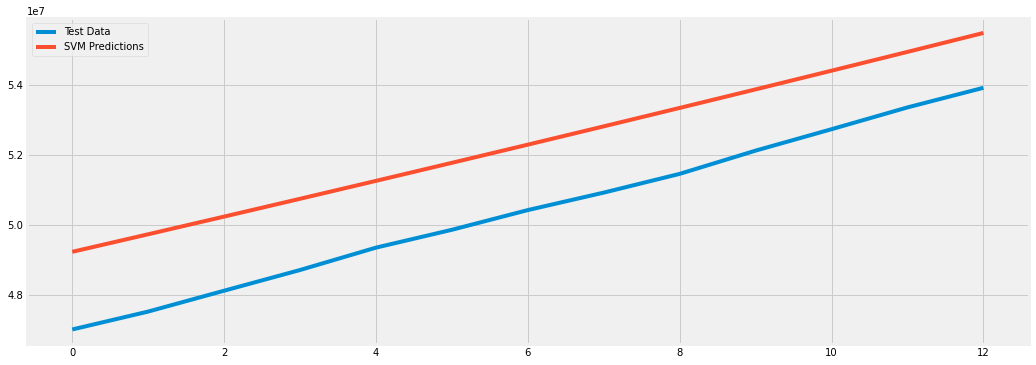

In [19]:
# check against testing data
plt.figure(figsize=(16,6))
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

## 8. Using Polynomial Regression

In [20]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=4)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [21]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 2646321.262460605
MSE: 7668268456125.988


In [22]:
print(linear_model.coef_)

[[-2.11823734e+06  5.65121127e+04 -4.91554578e+02  5.23811530e+00
  -7.53135287e-03]]


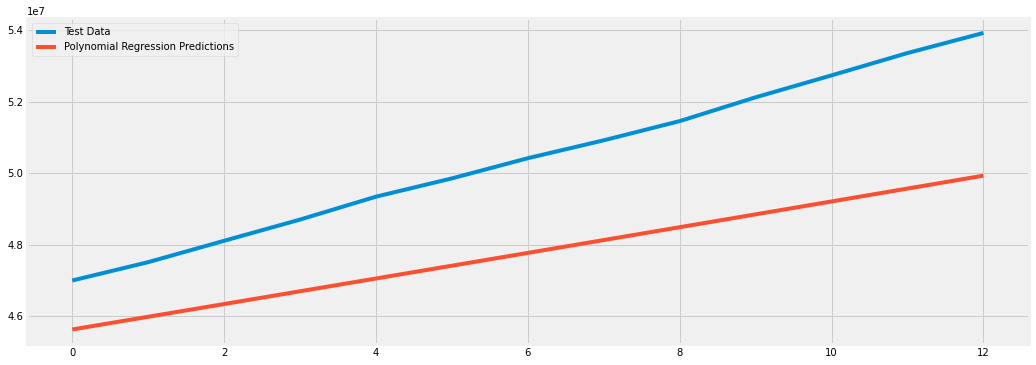

In [28]:
plt.figure(figsize=(16,6))
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

## 9. Using Bayesian ridge Polynomial Regression

In [24]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [25]:
bayesian_search.best_params_

{'alpha_1': 1e-07,
 'alpha_2': 1e-07,
 'lambda_1': 0.001,
 'lambda_2': 1e-06,
 'normalize': True,
 'tol': 0.001}

In [26]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 2416793.82098947
MSE: 6408371102126.4795


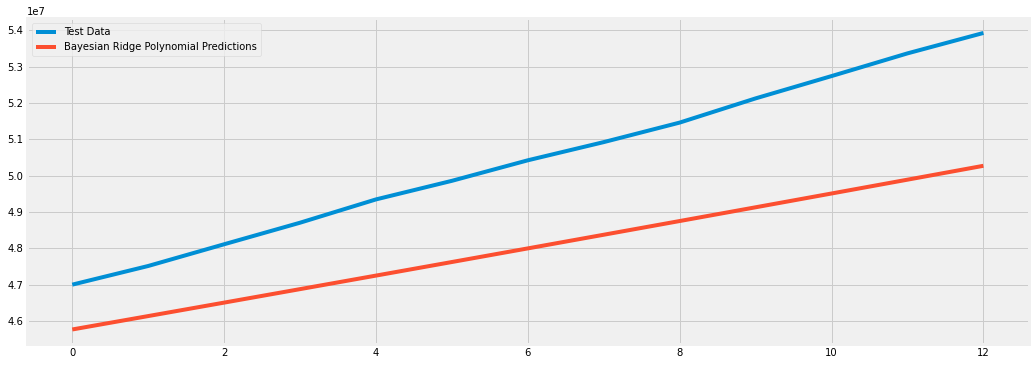

In [27]:
plt.figure(figsize=(16,6))
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

## 10. Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate (CFR), and recovery rate

In [29]:
def flatten(arr):
    a = [] 
    arr = arr.tolist()
    for i in arr:
        a.append(i[0])
    return a

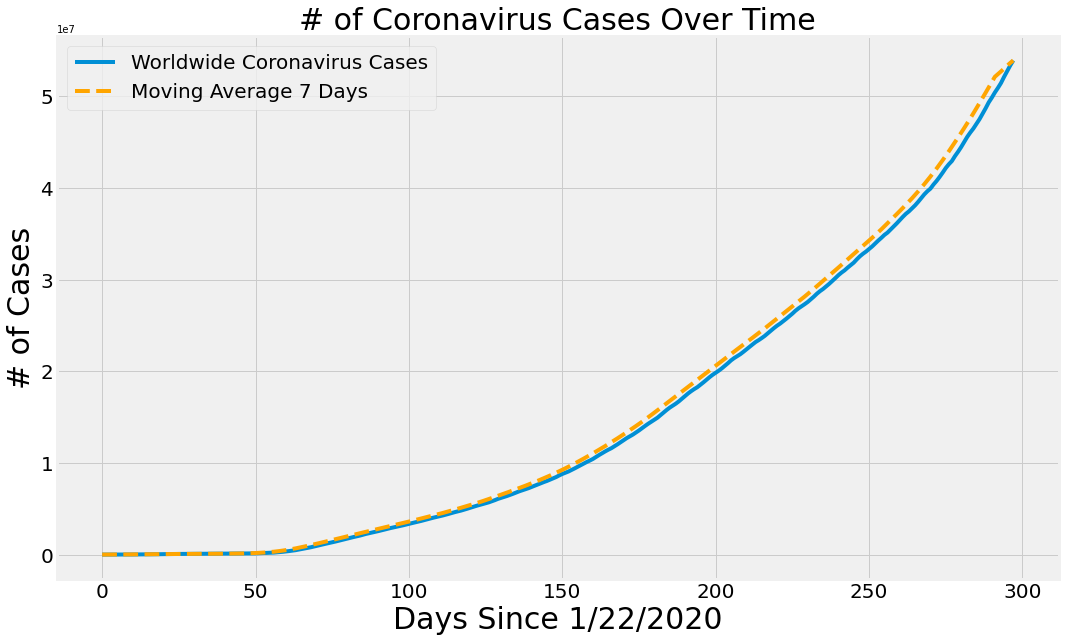

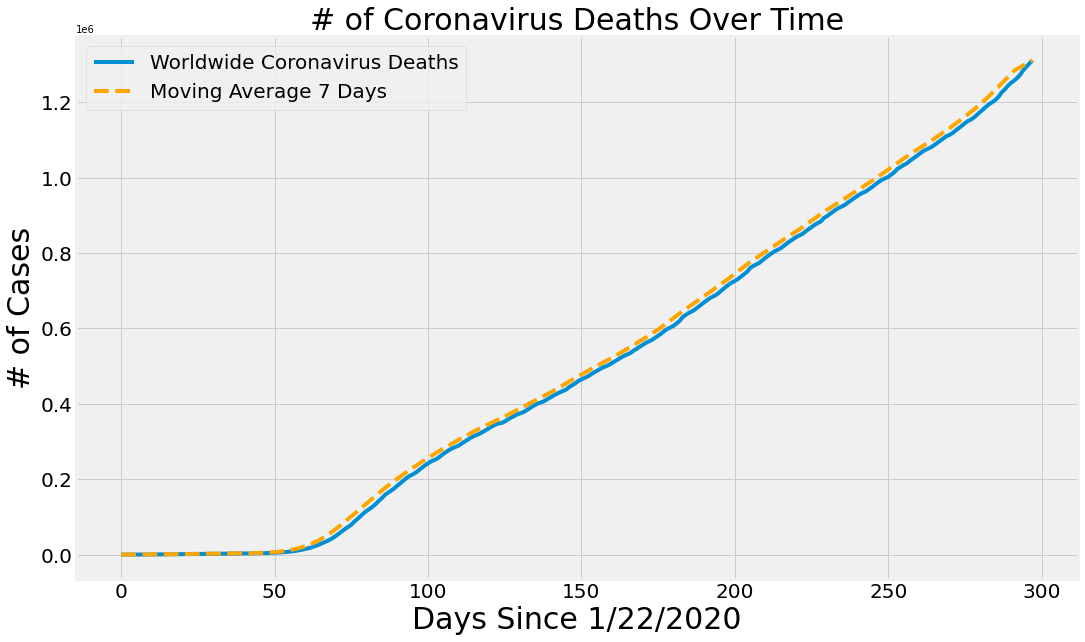

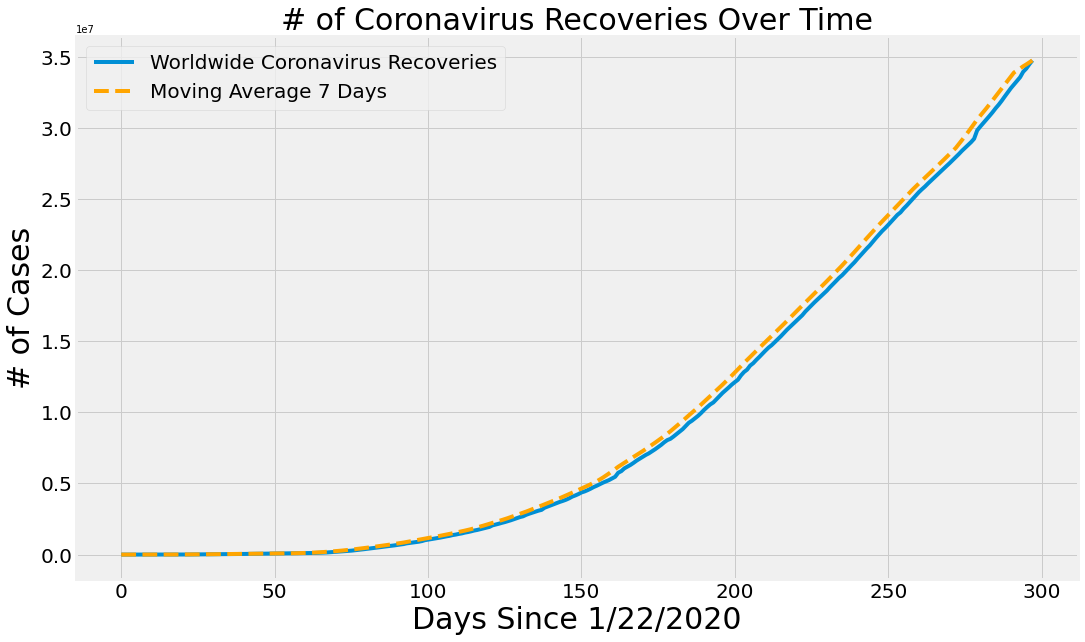

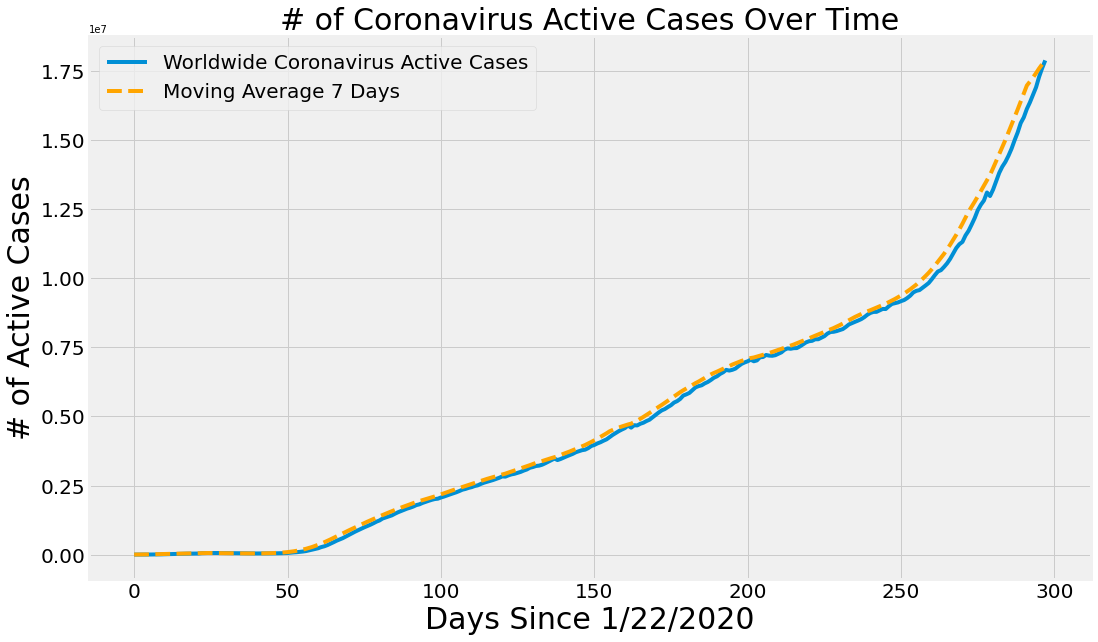

In [30]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths)
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_recovered)
plt.plot(adjusted_dates, world_recovery_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Recoveries', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_active)
plt.plot(adjusted_dates, world_active_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.legend(['Worldwide Coronavirus Active Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

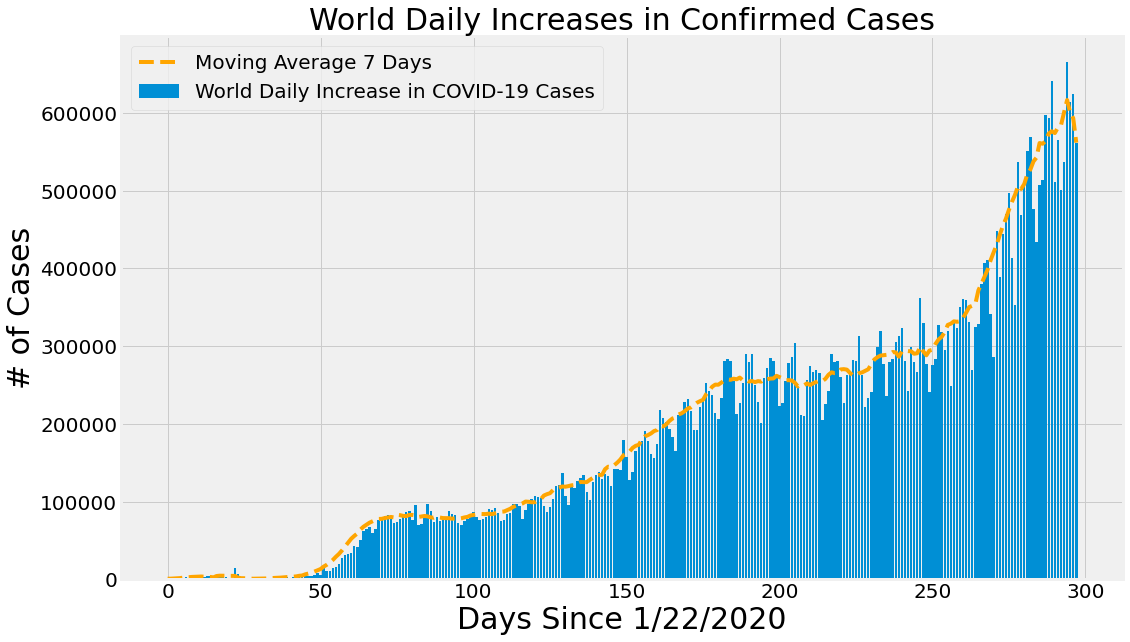

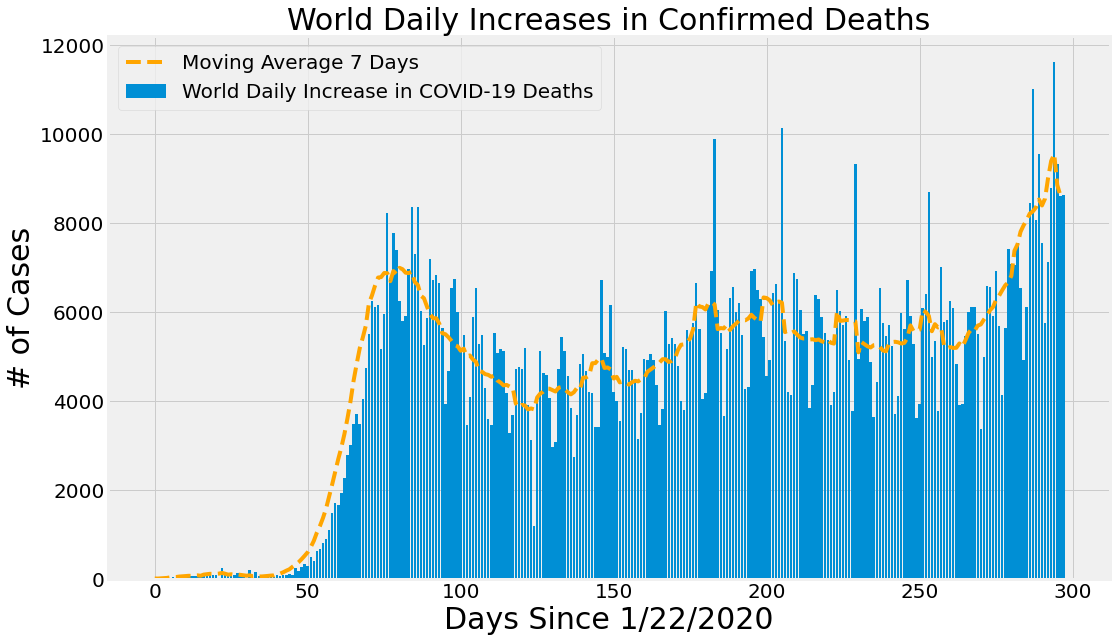

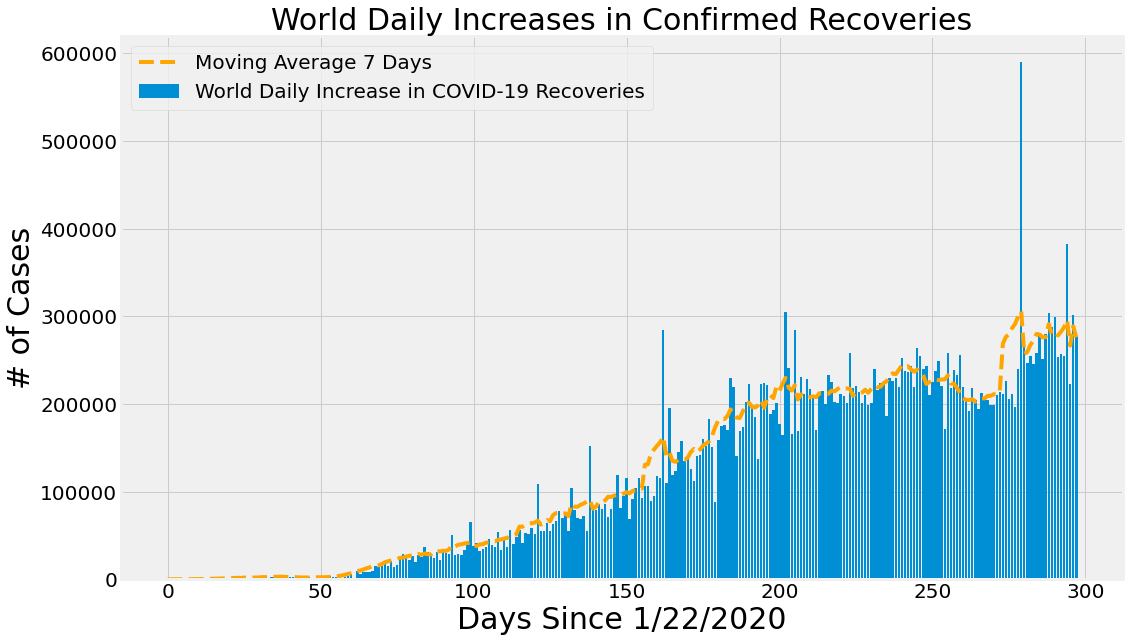

In [31]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_recovery)
plt.plot(adjusted_dates, world_daily_recovery_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Recoveries'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

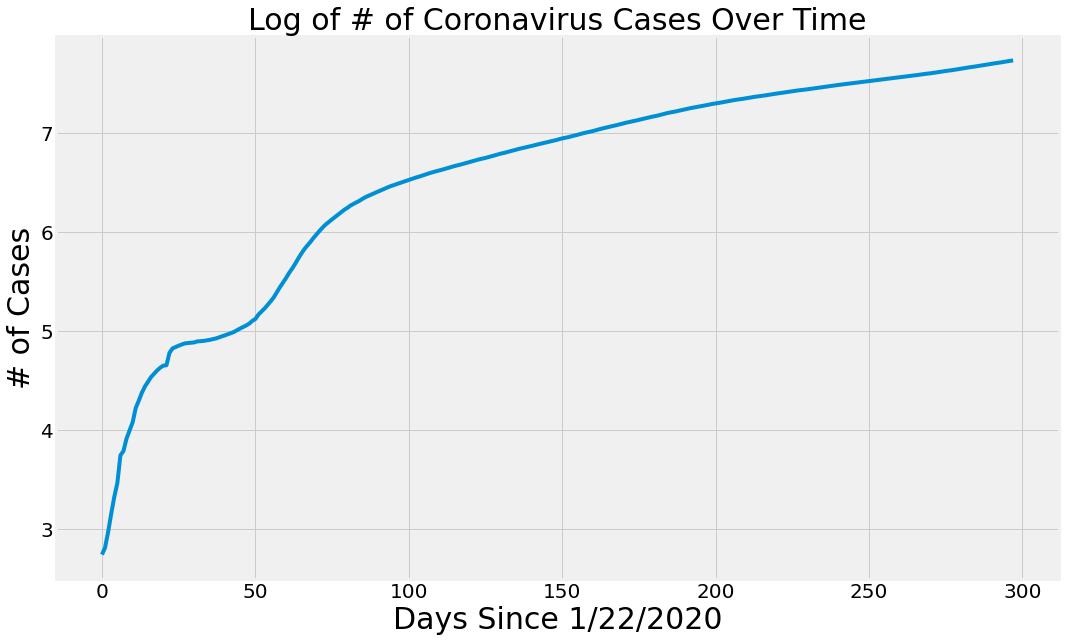

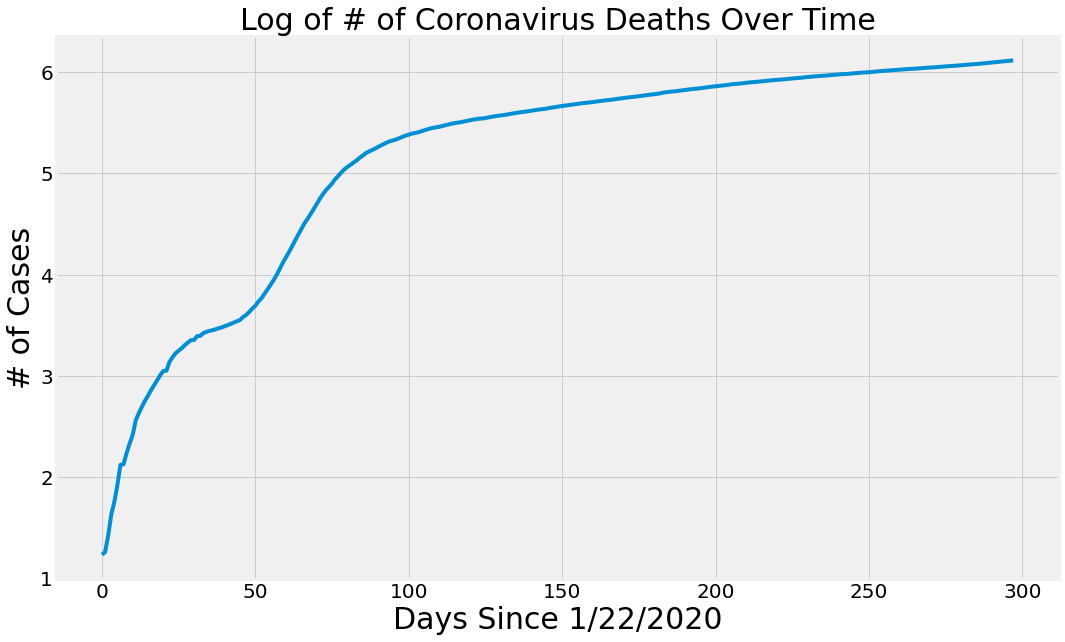

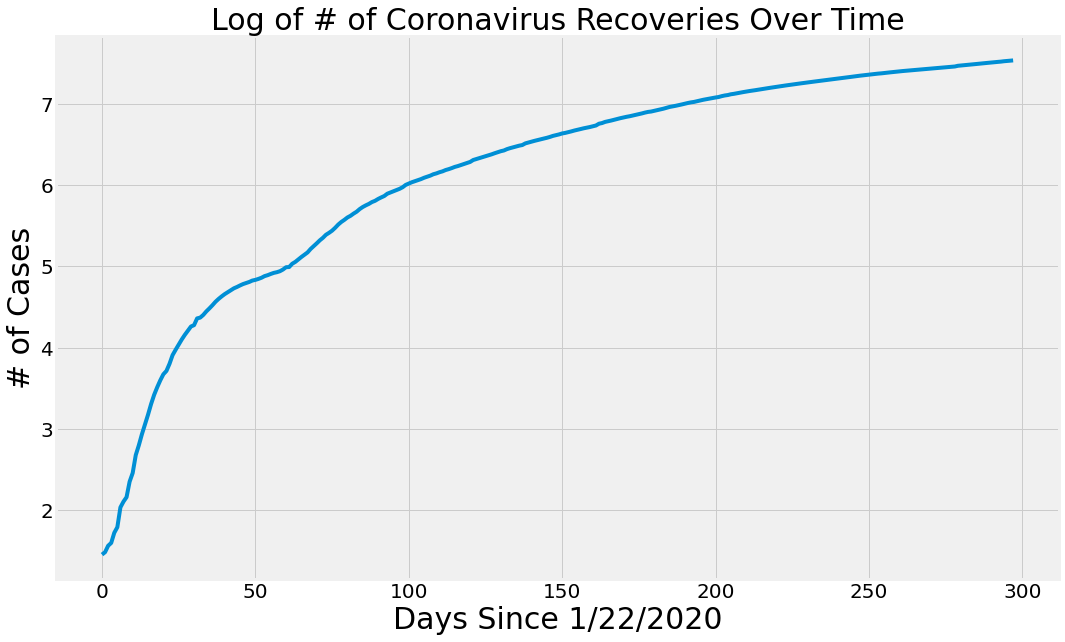

In [32]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(total_deaths))
plt.title('Log of # of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(total_recovered))
plt.title('Log of # of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [33]:
def country_plot(x, y1, y2, y3, y4, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
    recovery_increase_avg = moving_average(y4, window)
    
    plt.figure(figsize=(16, 10))
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y4)
    plt.plot(x, recovery_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Recoveries'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
      
# helper function for getting country's cases, deaths, and recoveries        
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    country_recoveries = []  
    
    for i in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
        country_recoveries.append(recoveries_df[recoveries_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths, country_recoveries)
    
    
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    country_recoveries = country_info[2]
    
    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
    country_daily_recovery = daily_increase(country_recoveries)
    
    country_plot(adjusted_dates, country_cases, country_daily_increase, country_daily_death, country_daily_recovery, country_name)

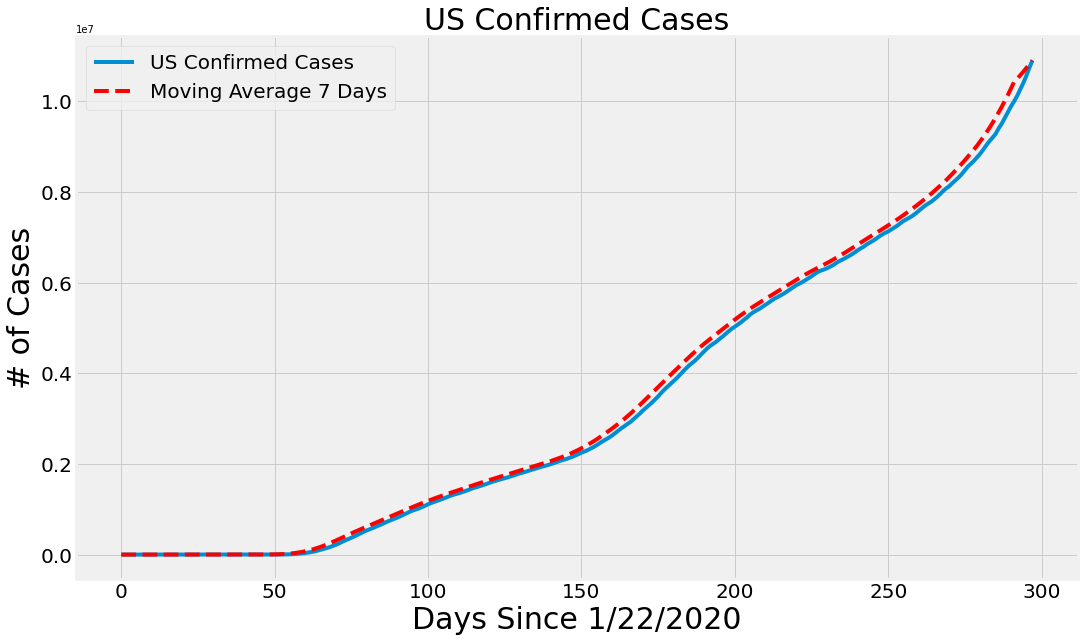

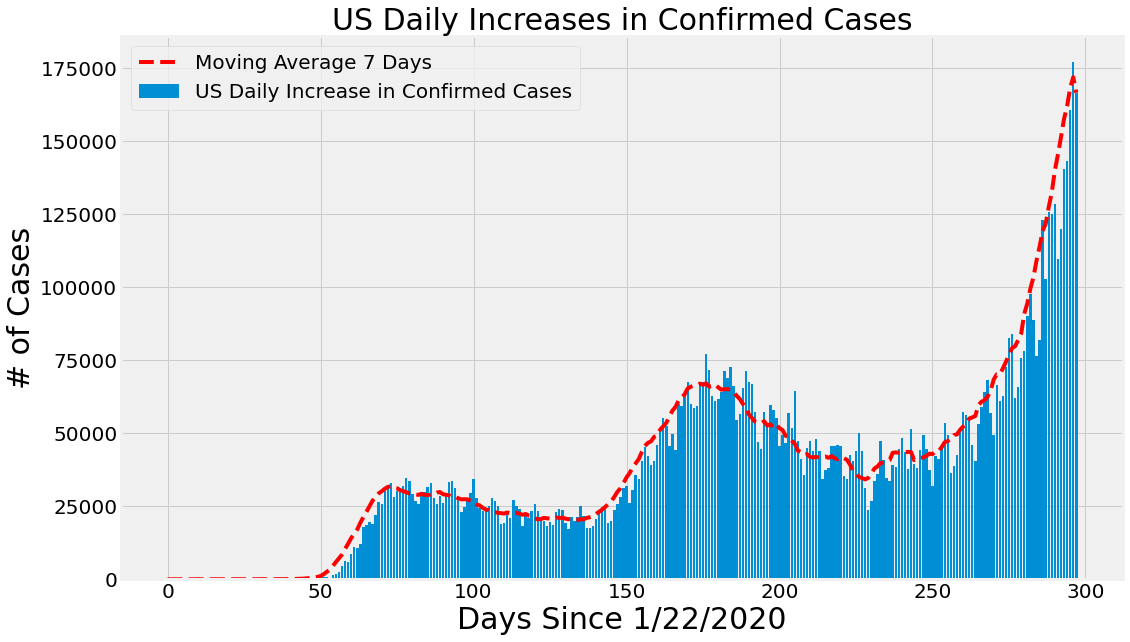

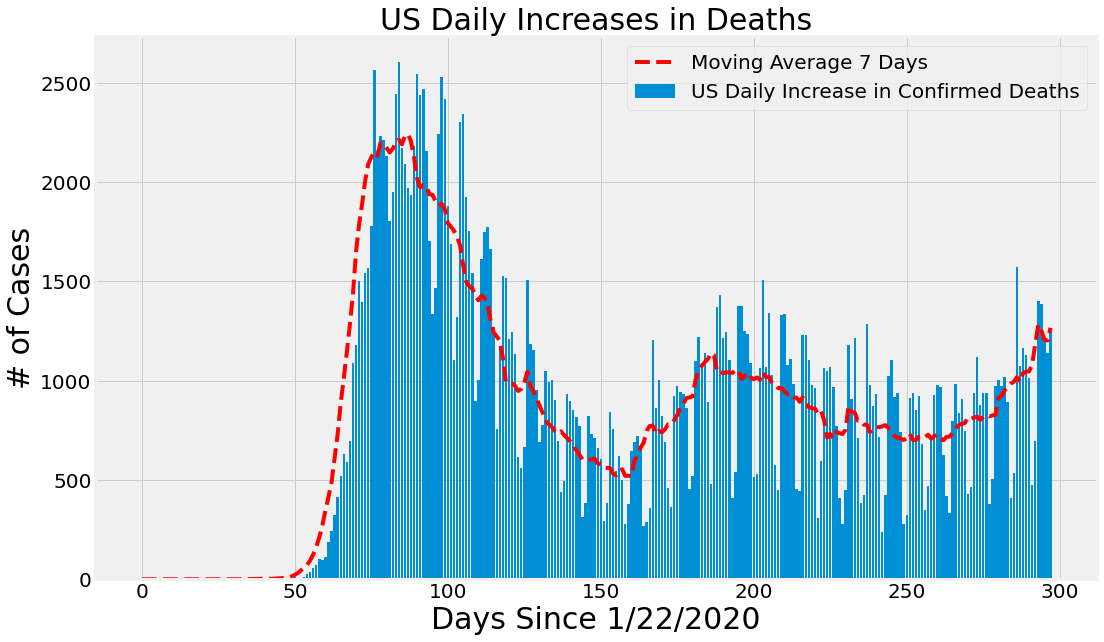

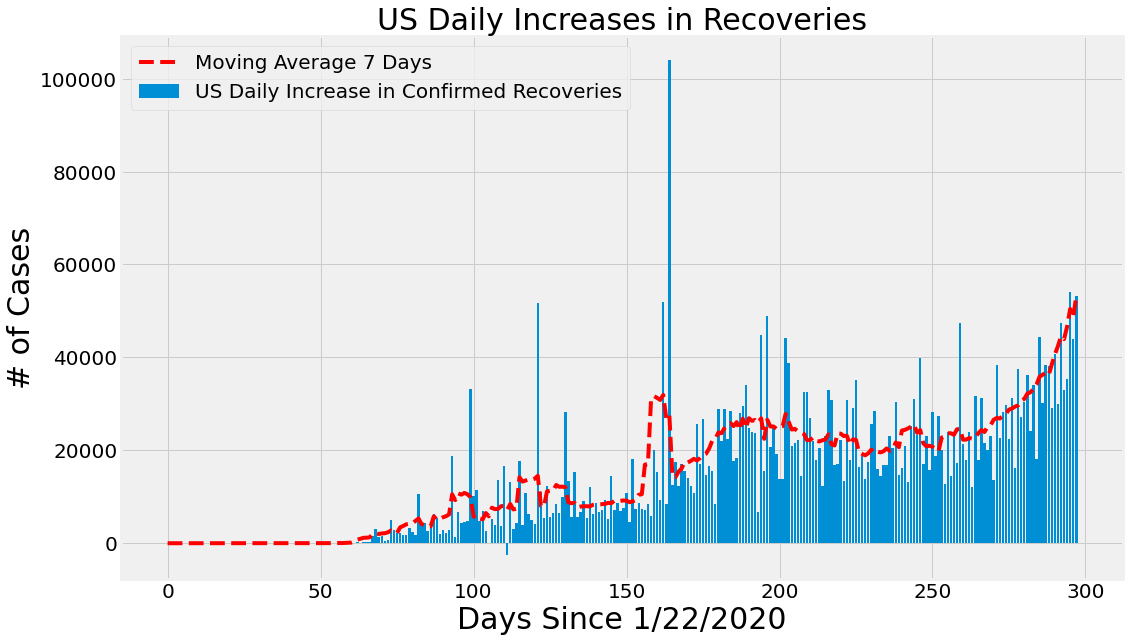

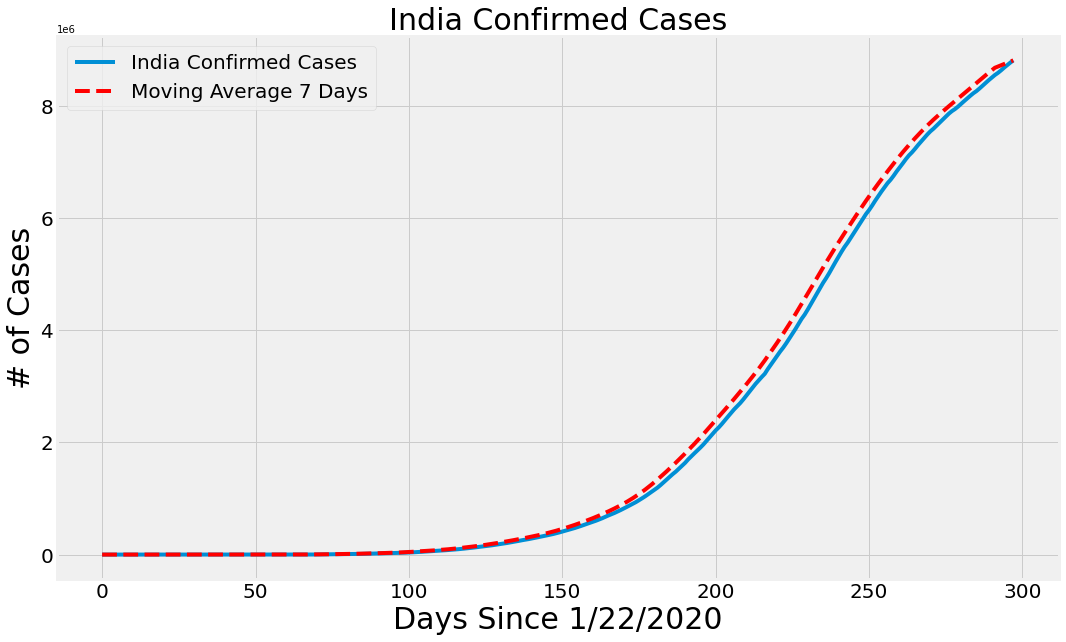

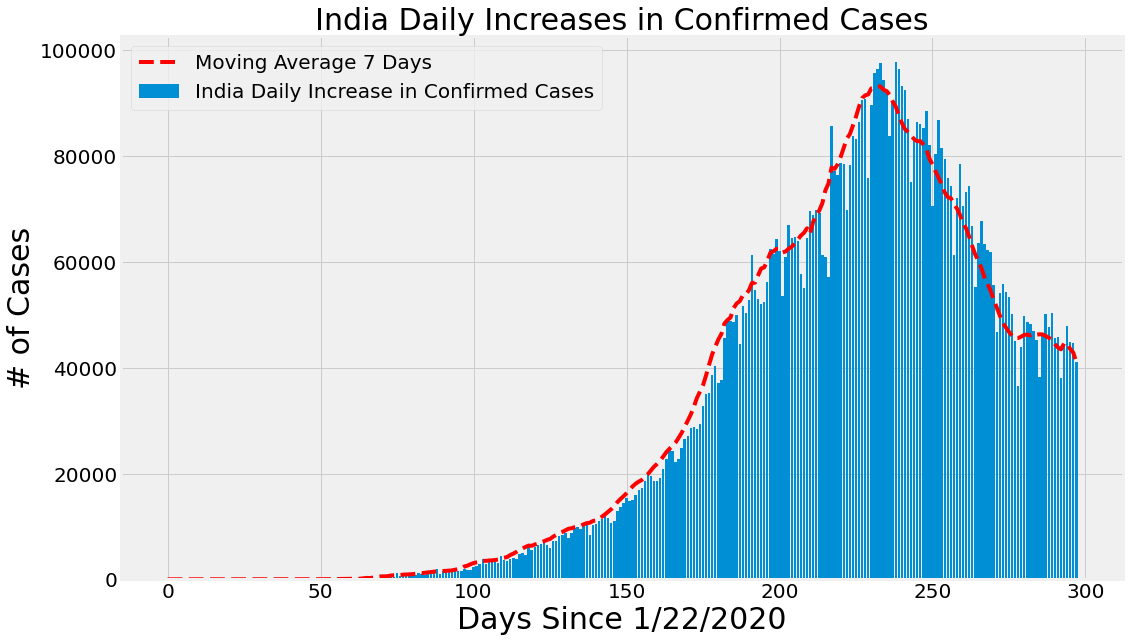

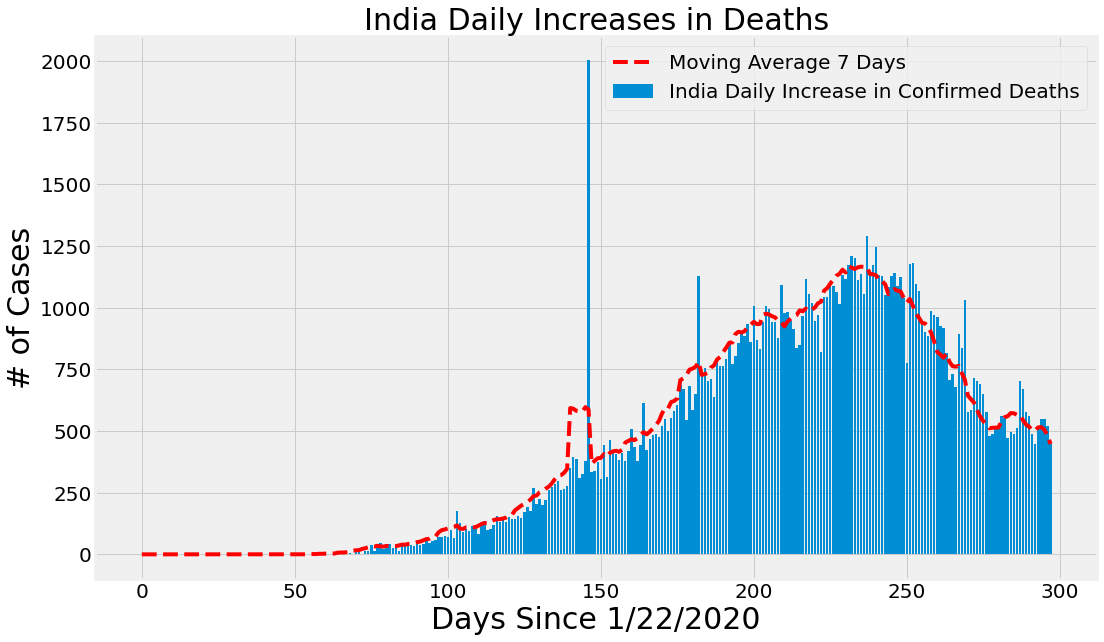

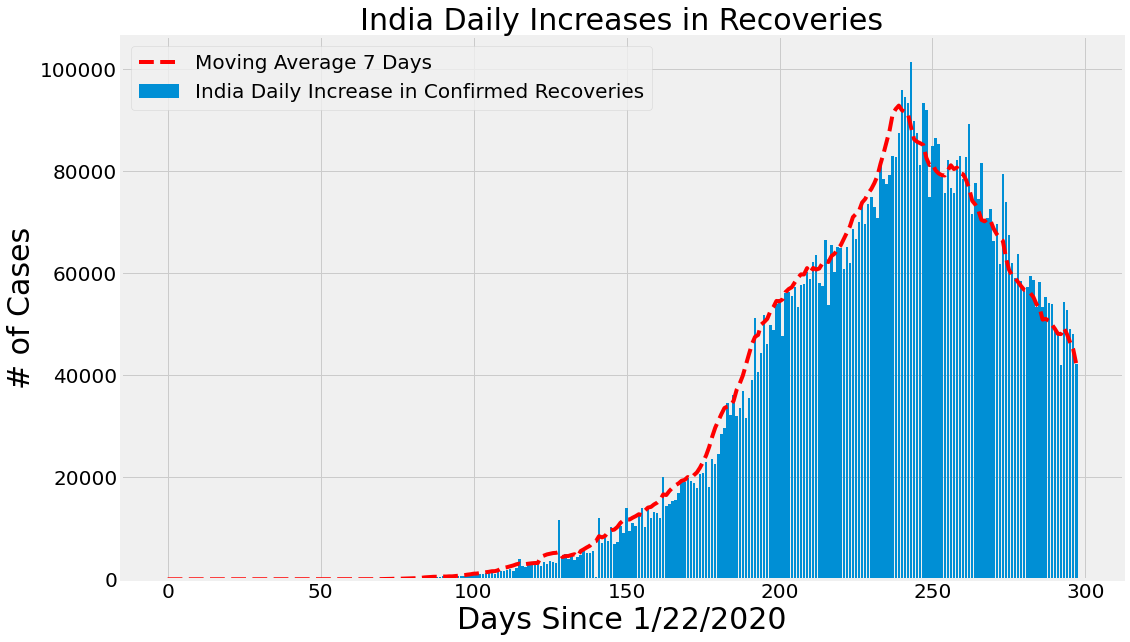

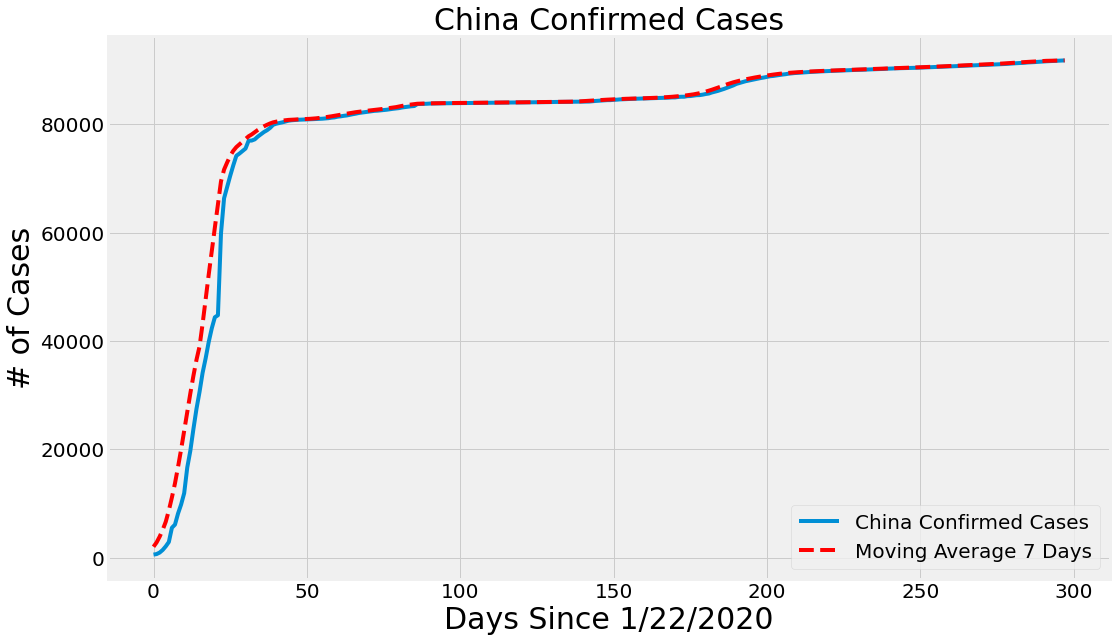

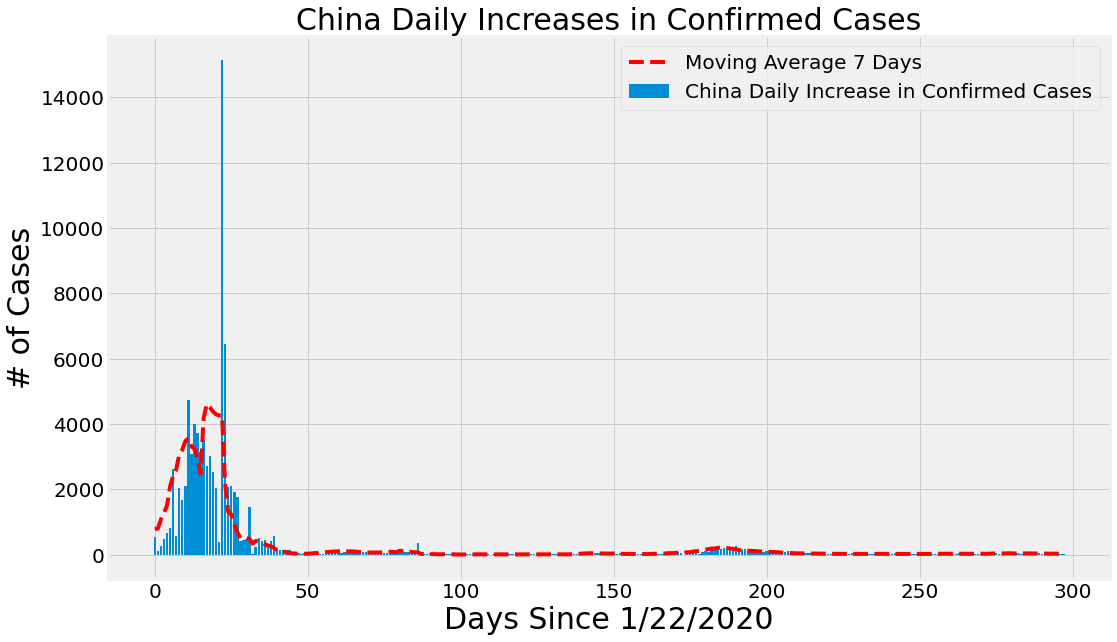

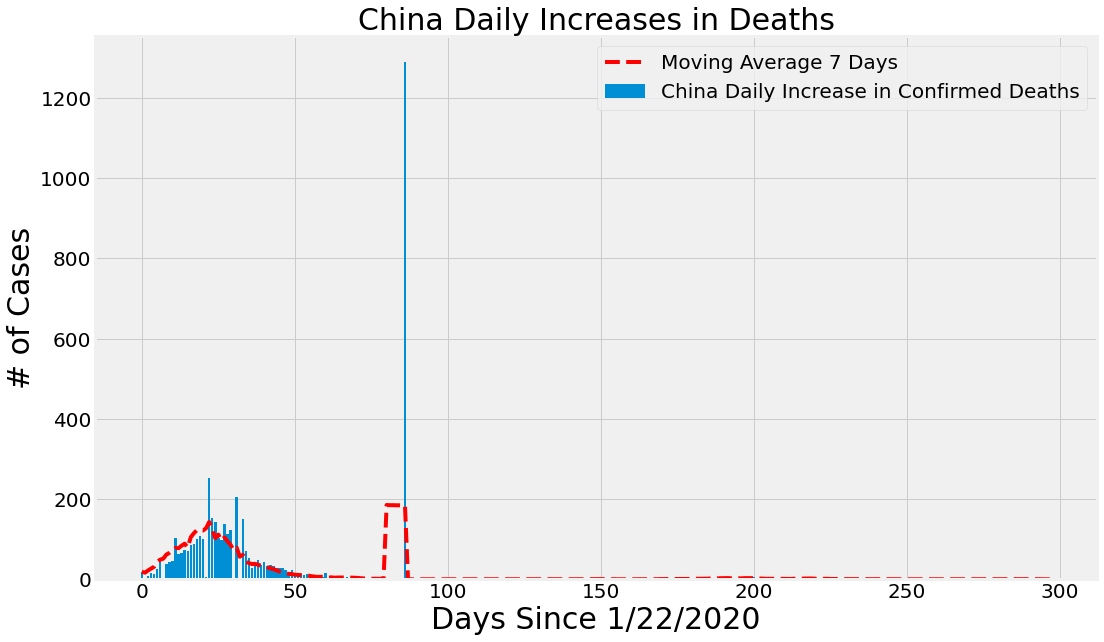

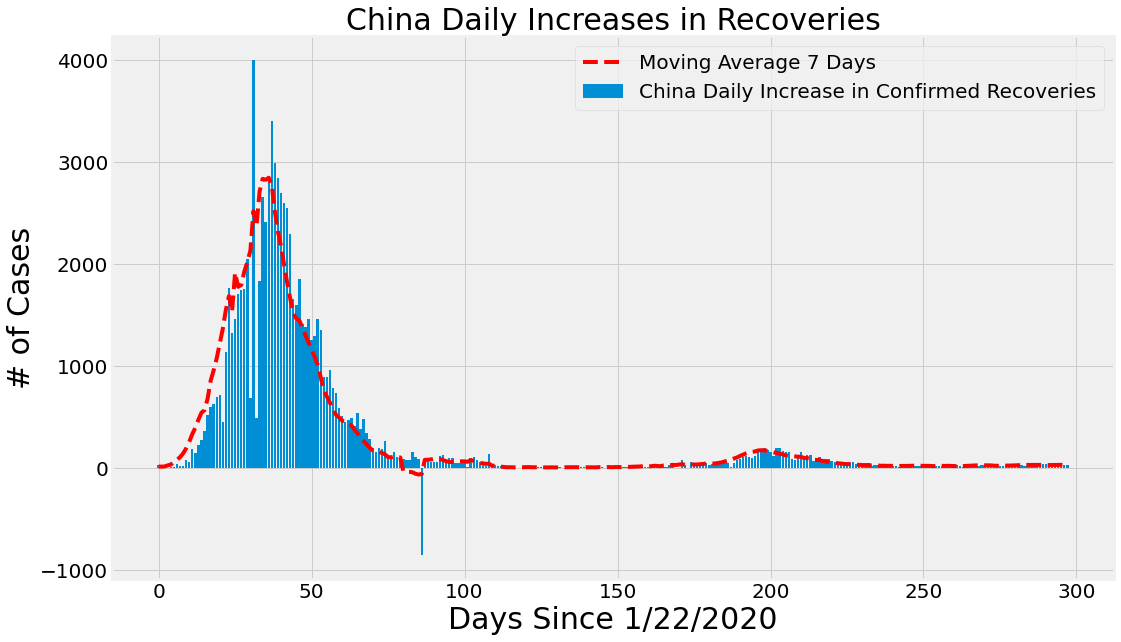

In [75]:
countries = ['US','India', 'China'] 

for country in countries:
    country_visualizations(country)

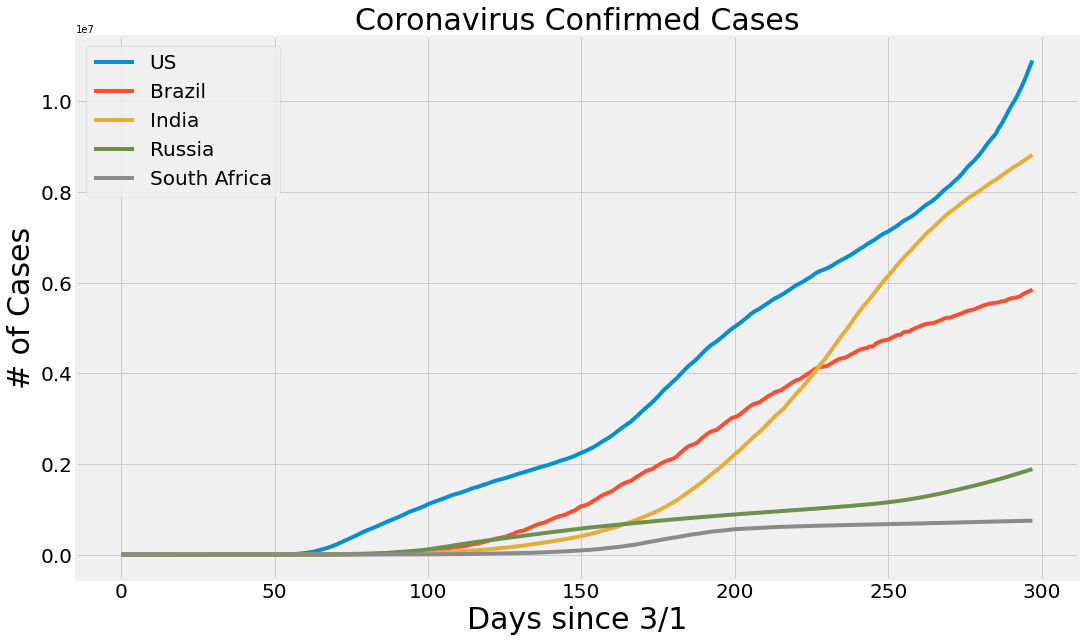

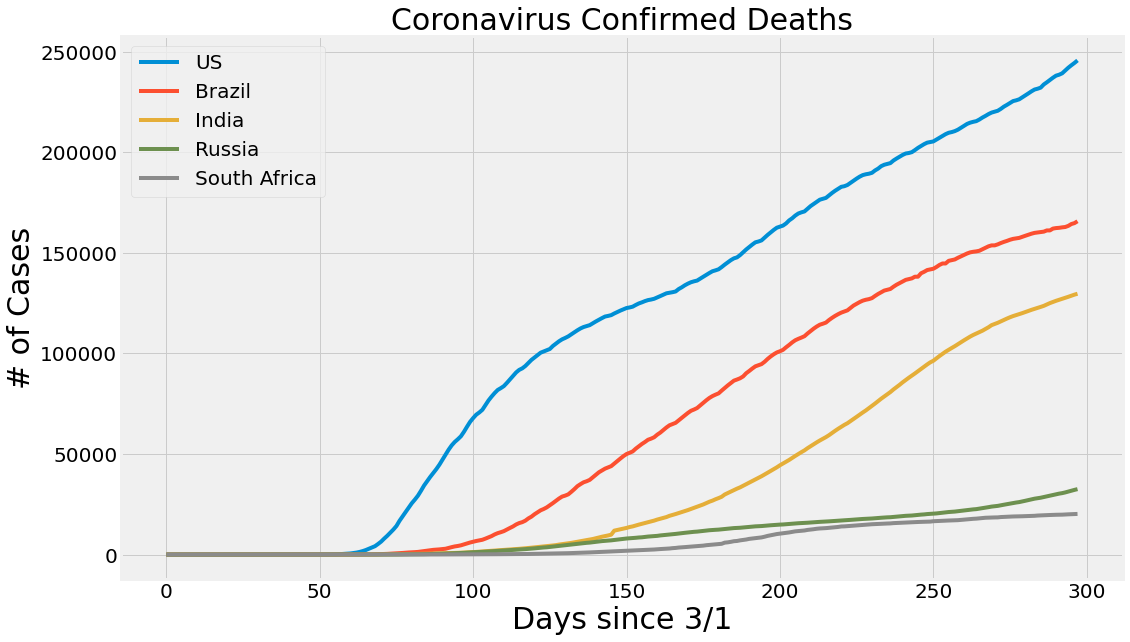

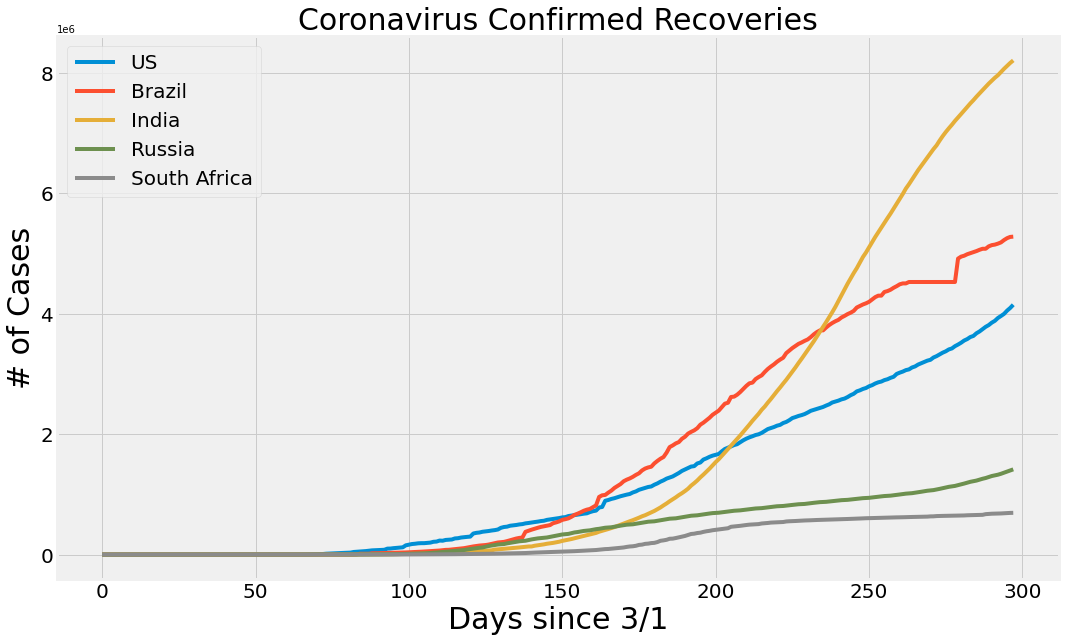

In [35]:

compare_countries = ['US', 'Brazil', 'India', 'Russia', 'South Africa'] 
graph_name = ['Coronavirus Confirmed Cases', 'Coronavirus Confirmed Deaths', 'Coronavirus Confirmed Recoveries']

for num in range(3):
    plt.figure(figsize=(16, 10))
    for country in compare_countries:
        plt.plot(get_country_info(country)[num])
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 3/1', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [36]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

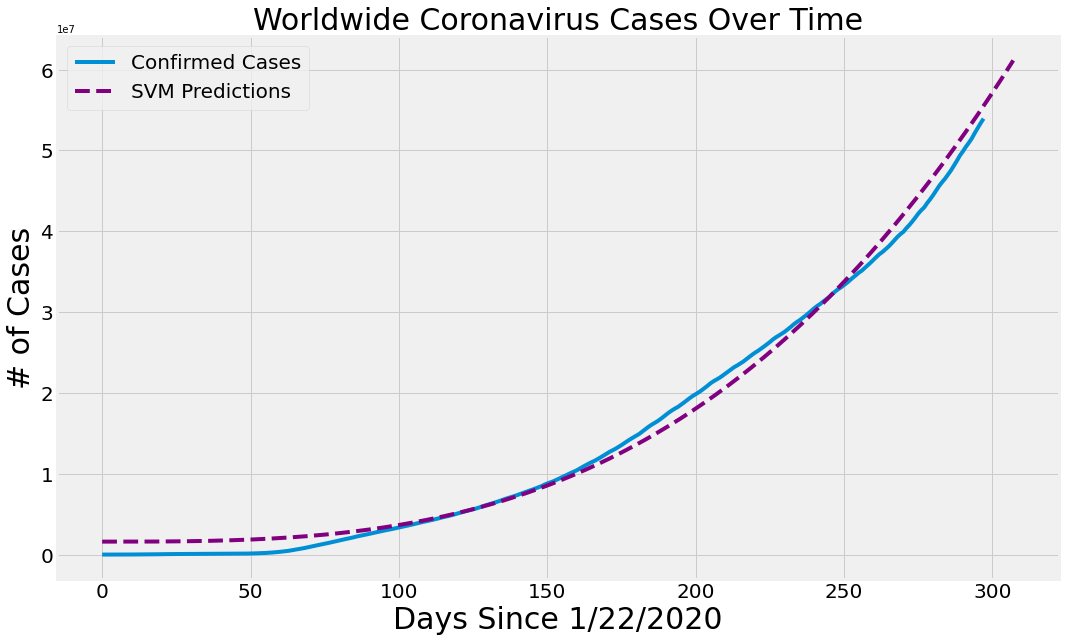

In [37]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

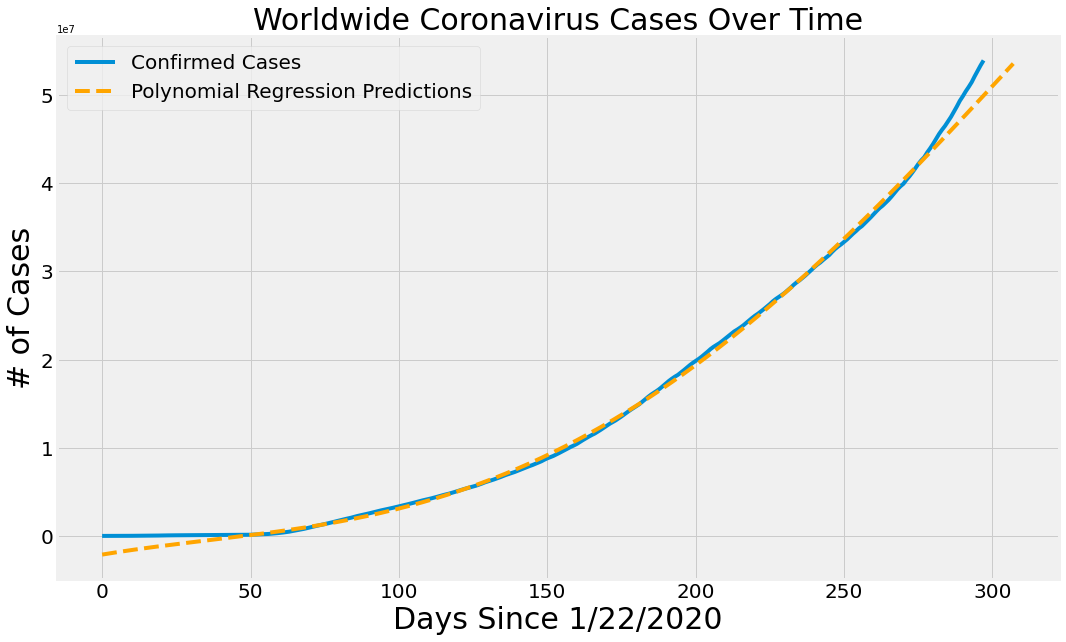

In [38]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

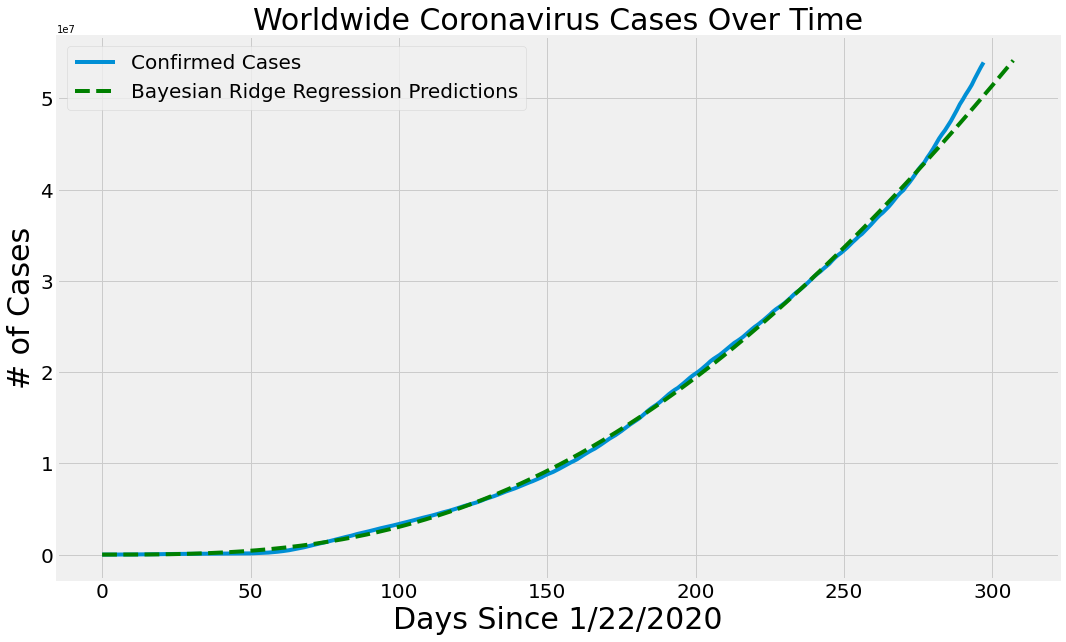

In [39]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [40]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Reds')

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,11/15/2020,56045193.000000
1,11/16/2020,56595099.000000
2,11/17/2020,57148696.000000
3,11/18/2020,57705996.000000
4,11/19/2020,58267011.000000
5,11/20/2020,58831754.000000
6,11/21/2020,59400237.000000
7,11/22/2020,59972472.000000
8,11/23/2020,60548472.000000
9,11/24/2020,61128248.000000


In [43]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Greens')

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,11/15/2020,50296324.000000
1,11/16/2020,50658314.000000
2,11/17/2020,51020639.000000
3,11/18/2020,51383276.000000
4,11/19/2020,51746201.000000
5,11/20/2020,52109392.000000
6,11/21/2020,52472825.000000
7,11/22/2020,52836477.000000
8,11/23/2020,53200325.000000
9,11/24/2020,53564344.000000


In [44]:
# Future predictions using Bayesian Ridge 
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Blues')

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,11/15/2020,50654290.000000
1,11/16/2020,51038174.000000
2,11/17/2020,51423161.000000
3,11/18/2020,51809246.000000
4,11/19/2020,52196420.000000
5,11/20/2020,52584677.000000
6,11/21/2020,52974010.000000
7,11/22/2020,53364411.000000
8,11/23/2020,53755874.000000
9,11/24/2020,54148391.000000


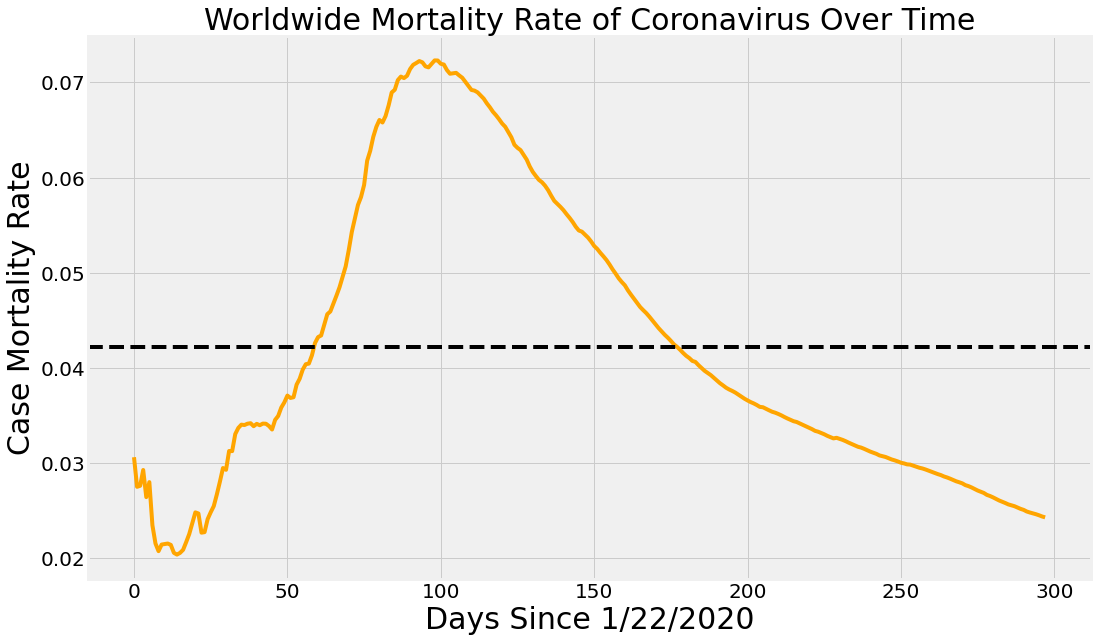

In [45]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Worldwide Mortality Rate of Coronavirus Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Case Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

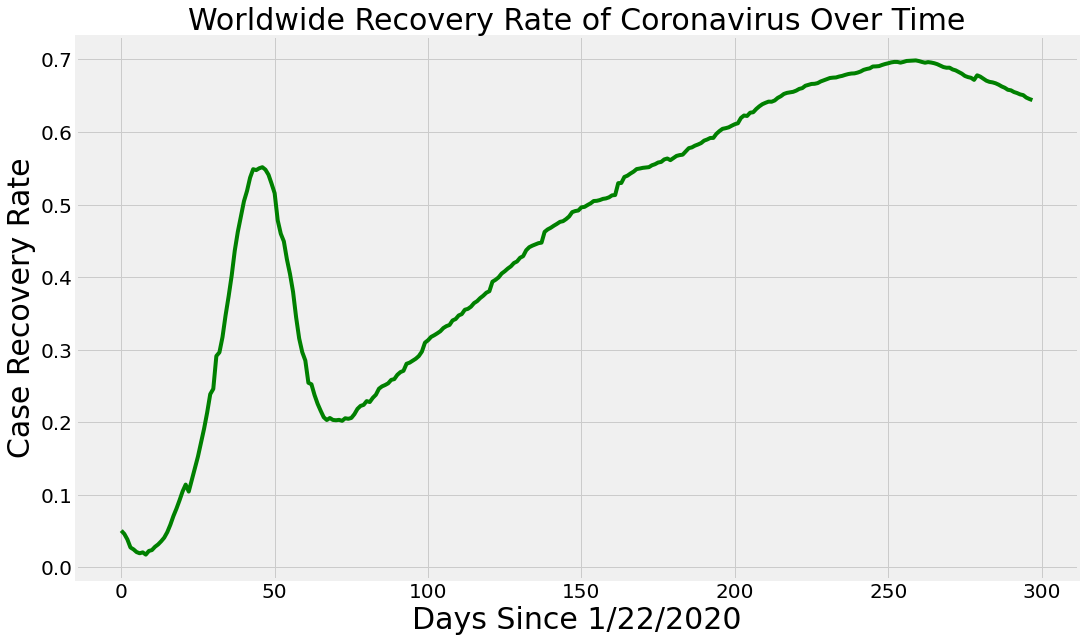

In [46]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, recovery_rate, color='green')
plt.title('Worldwide Recovery Rate of Coronavirus Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Case Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

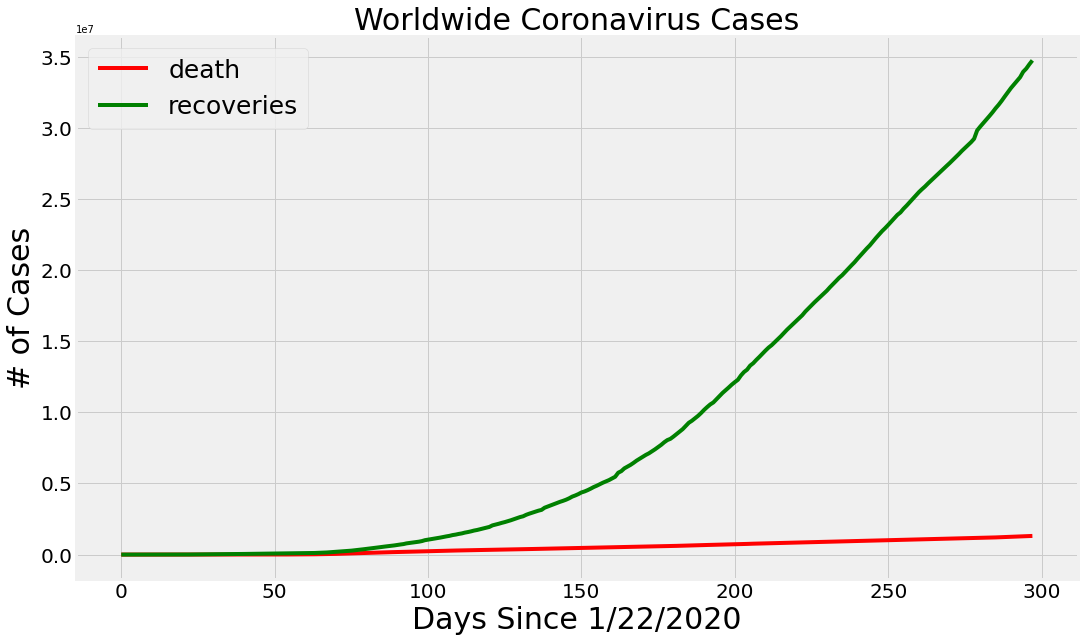

In [47]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=25)
plt.title('Worldwide Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

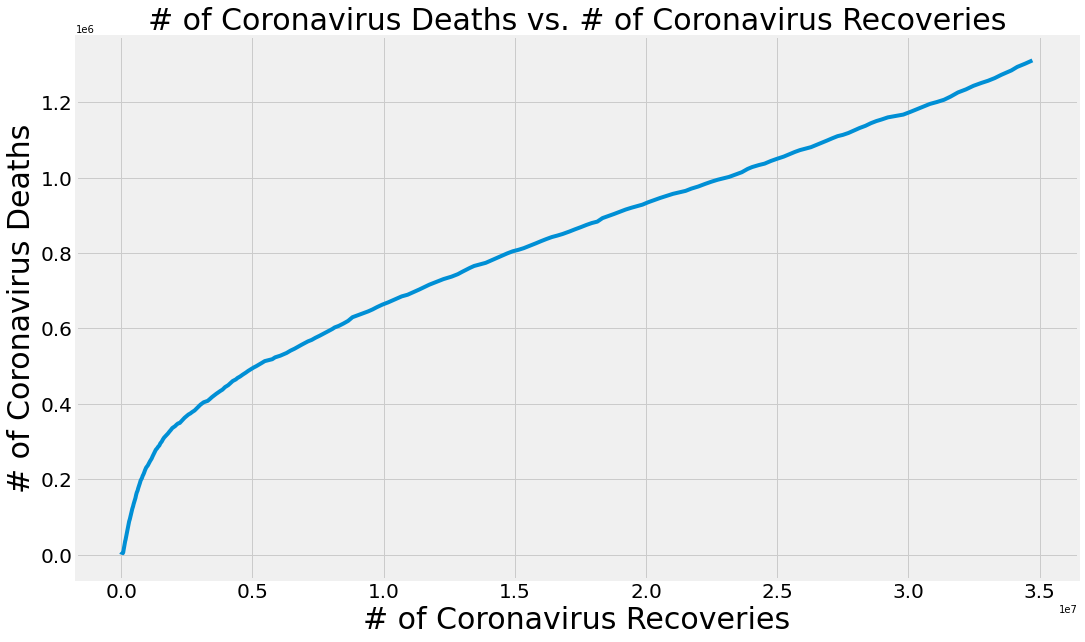

In [48]:
plt.figure(figsize=(16, 10))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [50]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [51]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_incidence_rate = [] 
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Active'].sum())
    country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incident_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [52]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases, 'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Oranges')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Incidence Rate,Mortality Rate
0,US,10903890,245598,4148444,6509848.000000,11365322.342355,0.022524
1,India,8814579,129635,8205728,479216.000000,31949.470378,0.014707
2,Brazil,5848959,165658,5279452,403849.000000,100228.770063,0.028323
3,France,1915713,42600,139760,1733371.000000,19599.227388,0.022237
4,Russia,1887836,32536,1415213,440087.000000,113645.705798,0.017235
5,Spain,1458591,40769,150376,1267446.000000,61068.070889,0.027951
6,United Kingdom,1347907,51858,3108,1292941.000000,15253.552951,0.038473
7,Argentina,1304846,35307,1119366,150173.000000,2887.097173,0.027058
8,Colombia,1191634,33829,1097576,60229.000000,68717.715499,0.028389
9,Italy,1144552,44683,411434,688435.000000,38662.768389,0.039040


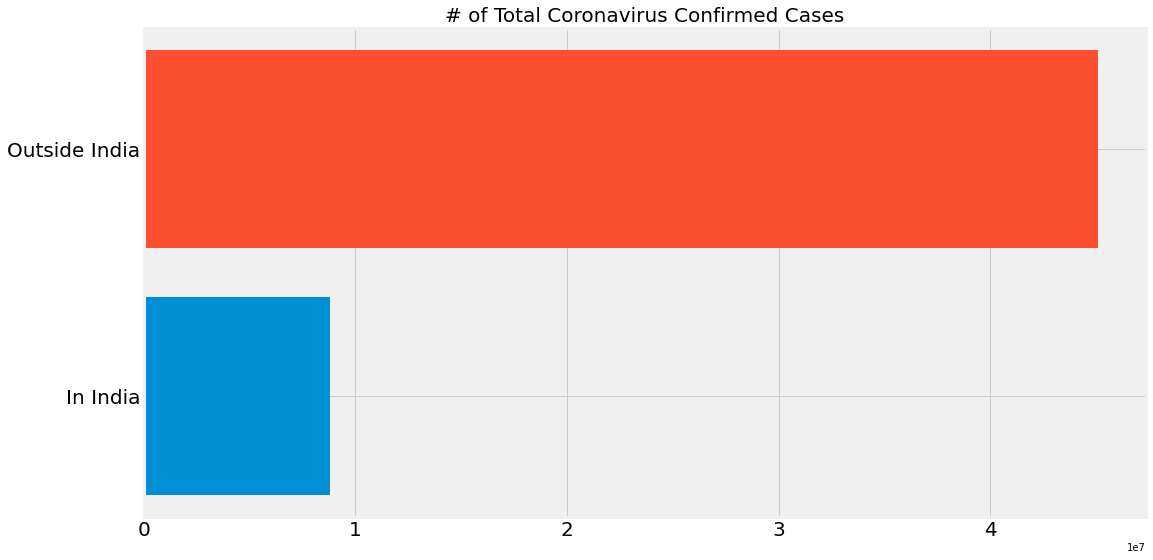

In [57]:
total_world_cases = np.sum(country_confirmed_cases)
india_confirmed = latest_data[latest_data['Country_Region']=='India']['Confirmed'].sum()
outside_india_confirmed = total_world_cases - india_confirmed

plt.figure(figsize=(16, 9))
plt.barh('In India', india_confirmed)
plt.barh('Outside India', outside_india_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


In [58]:
print('Outside India {} cases ({}%):'.format(outside_india_confirmed, np.round((outside_india_confirmed/total_world_cases)*100, 1)))
print('In India {} cases ({}%)'.format(india_confirmed, np.round((india_confirmed/total_world_cases)*100, 1)))
print('Total: {} cases'.format(total_world_cases))

Outside India 45112579 cases (83.7%):
In India 8814579 cases (16.3%)
Total: 53927158 cases


In [59]:
# Only show 15 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

In [60]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 12))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    
# good for a lot x values 
def plot_bar_graphs_tall(x, y, title):
    plt.figure(figsize=(19, 18))
    plt.barh(x, y)
    plt.title(title, size=25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()

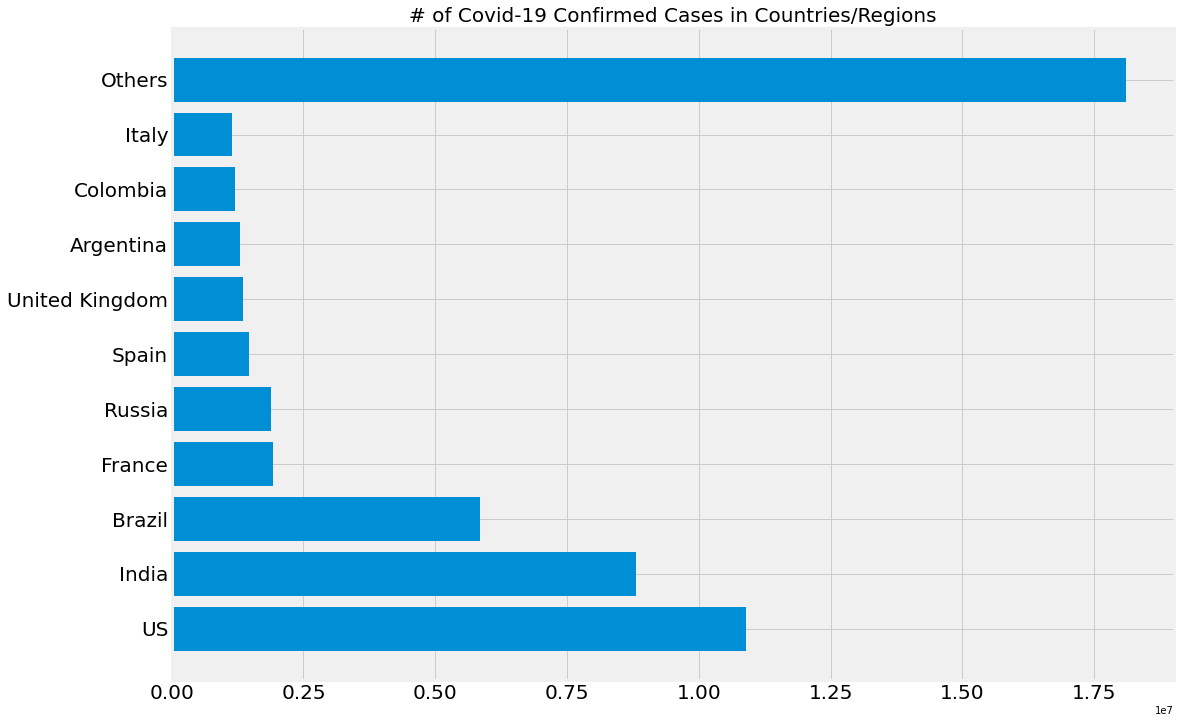

In [61]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

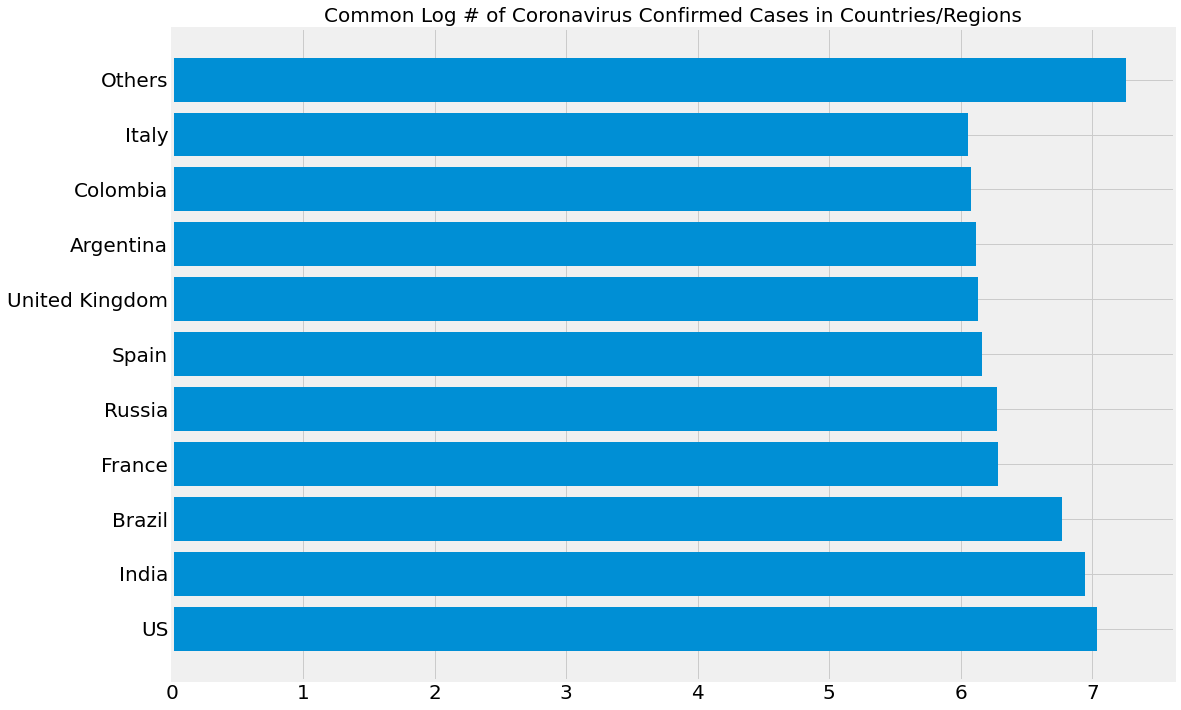

In [67]:
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plot_bar_graphs(visual_unique_countries, log_country_confirmed_cases,'Common Log # of Coronavirus Confirmed Cases in Countries/Regions')

In [69]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c,shadow=True, labels=y)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

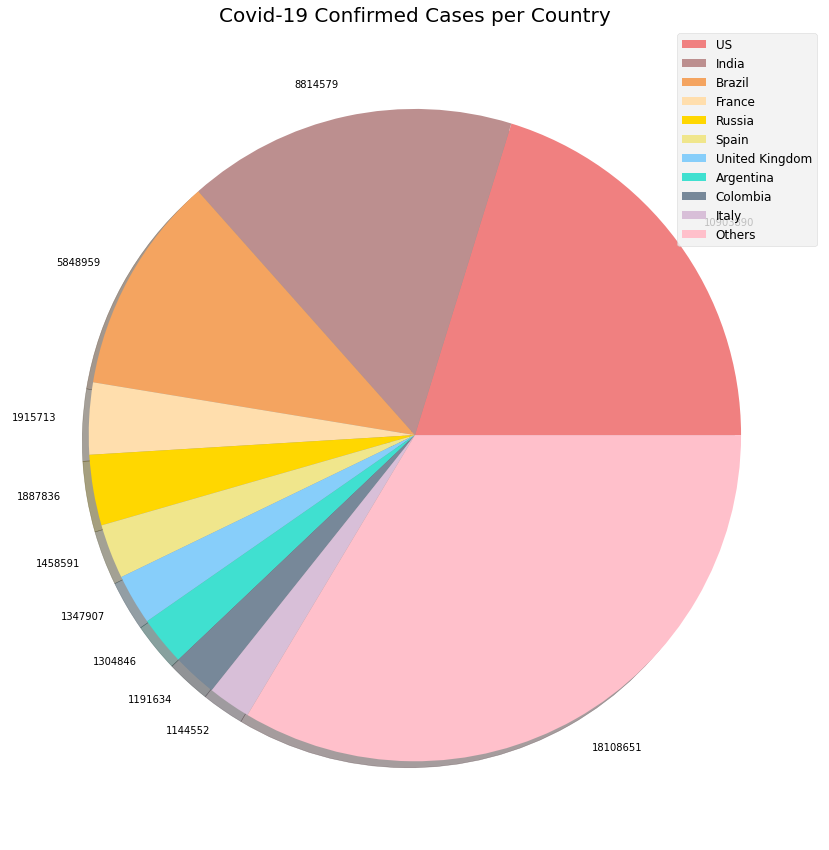

In [70]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')

In [72]:
# Plotting countries with regional data using a pie chart 

def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 5 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"
    
    if(len(regions)>5):
        regions_5 = regions[:5]
        regions_5.append('Others')
        confirmed_cases_5 = confirmed_cases[:5]
        confirmed_cases_5.append(np.sum(confirmed_cases[5:]))
        plot_pie_charts(regions_5,confirmed_cases_5, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)


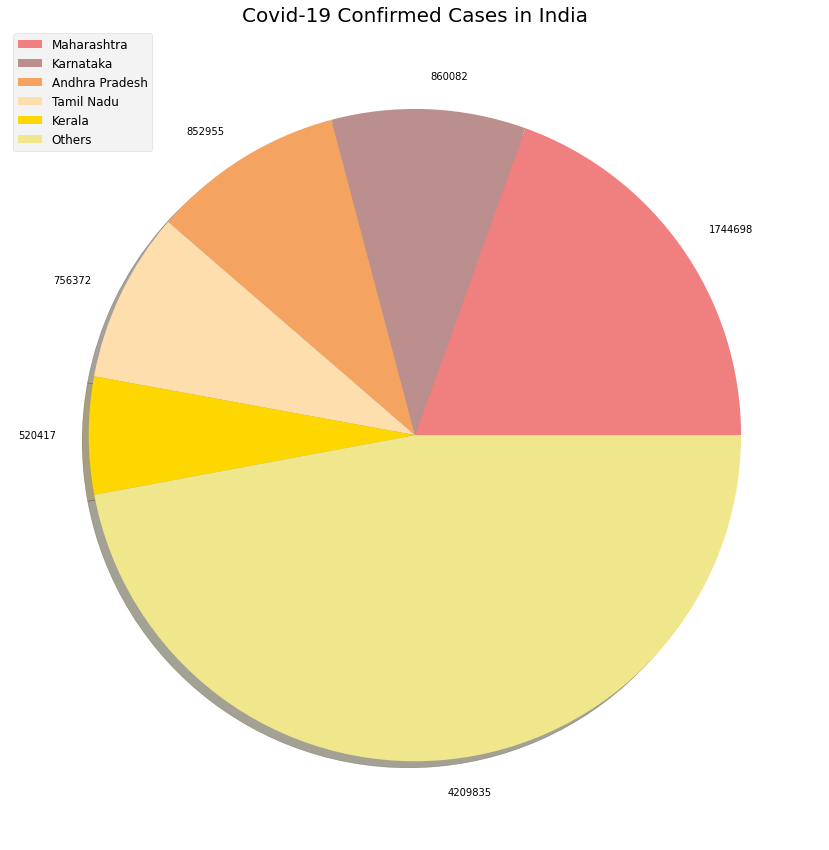

In [73]:
pie_chart_countries = ['India']

for i in pie_chart_countries:
    plot_pie_country_with_regions(i, 'Covid-19 Confirmed Cases in {}'.format(i))

## Conclusion :

### From the detailed analysis and prediction report we can say that although Covid-19 infections are soaring to peak,the recovery rate is also promisingly high. This suggests the malignancy of the disease has been reduced to a lot in the past time and there is a greater chance of getting cured if a person is infected by this virus.


## Important Note:

### Please don't ignore the severity of the virus infections as the death rates are also considerably high and is potentially fatal for people with weak immuninty.

### So, remember to wash your hands, wear masks and mainatan social distancing.  One day we will overcome. 😊